In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest
from pmdarima.arima import nsdiffs

In [2]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## General Model

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])

df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


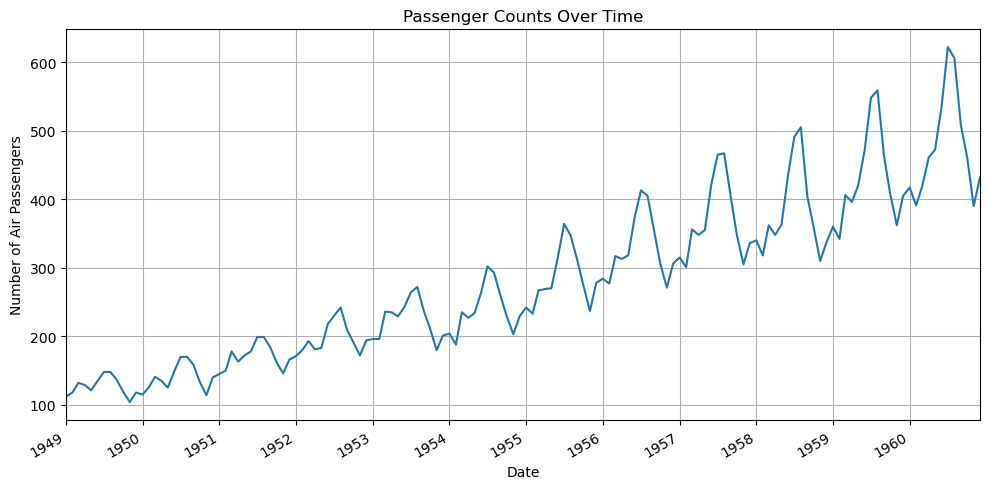

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot
ax.plot(df.index, df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Air Passengers')
ax.set_title('Passenger Counts Over Time')
ax.set_xlim(pd.to_datetime('1949-01-01'), pd.to_datetime('1960-12-01'))

# Use 12 ticks for 1949–1960
tick_dates = pd.date_range(start='1949', end='1960', freq='YS')
tick_labels = np.arange(1949, 1961, 1)

ax.set_xticks(tick_dates)
ax.set_xticklabels(tick_labels)
plt.grid(True)    

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [6]:
# Convert to datetime for the comparison
train = df[df.index < pd.to_datetime('1960-01-01')]     # All data before date
test = df[df.index >= pd.to_datetime('1960-01-01')]     # All data in date and beyond

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (132, 1)
Test shape: (12, 1)




(            Passengers
 Month                 
 1959-08-01         559
 1959-09-01         463
 1959-10-01         407
 1959-11-01         362
 1959-12-01         405,
 None,
             Passengers
 Month                 
 1960-01-01         417
 1960-02-01         391
 1960-03-01         419
 1960-04-01         461
 1960-05-01         472)

In [7]:
airline_series = train['Passengers']

In [8]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(airline_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.8880, p-value = 0.9929
d = 1 | ADF Statistic = -2.4029, p-value = 0.1409
d = 2 | ADF Statistic = -14.2529, p-value = 0.0000

Non-seasonal differencing term (d): 2


In [9]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(airline_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 1
Seasonal differencing term (D) for 24: 1
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 1


### 1. Canova-Hansen Test (`ch`)

- **Type**: Spectral test for seasonal stationarity  
- **Focus**: Tests for seasonal unit roots  

**Strengths**:
- Designed for **monthly** or **quarterly** data  
- More **robust to noise**  

**Best Use Case**:  
Use when you're unsure about the presence of seasonal effects and want a **conservative decision**.

---

### 2. OCSB Test (`ocsb`) — *Osborn-Chui-Smith-Birchenhall*

- **Type**: Regression-based test for seasonal integration  
- **Focus**: Checks if seasonal differencing improves stationarity  

**Strengths**:
- Can detect **weaker seasonal signals**  
- Based on a **statistical regression model**  

**Best Use Case**:  
Use when you suspect **subtle or complex seasonal patterns**.

---

### Which is Better?

| **Criteria**                     | **`ch` (Canova-Hansen)** | **`ocsb`**                  |
|----------------------------------|---------------------------|-----------------------------|
| Robust to noise                 | ✅ Yes                    | ❌ Less robust              |
| Detects subtle seasonality      | ❌ Not as sensitive        | ✅ More sensitive           |
| More conservative               | ✅ Yes                    | ❌ No                       |
| Recommended for automation      | ✅ Yes (default in many tools) | ⚠ Use with caution     |

---

### In Practice:

- Use `test='ch'` as the **default**, especially for **cleaner or strongly seasonal** data.
- Use `test='ocsb'` if:
  - You suspect **mild seasonal effects**
  - You want to **double-check** `ch` results

In [10]:
from pmdarima.arima import nsdiffs

D = nsdiffs(airline_series, m=12, test='ch') # Canova-Hansen Test (ch) is designed for monthly or quarterly data.
print("Seasonal differencing term (D):", D)

Seasonal differencing term (D): 0


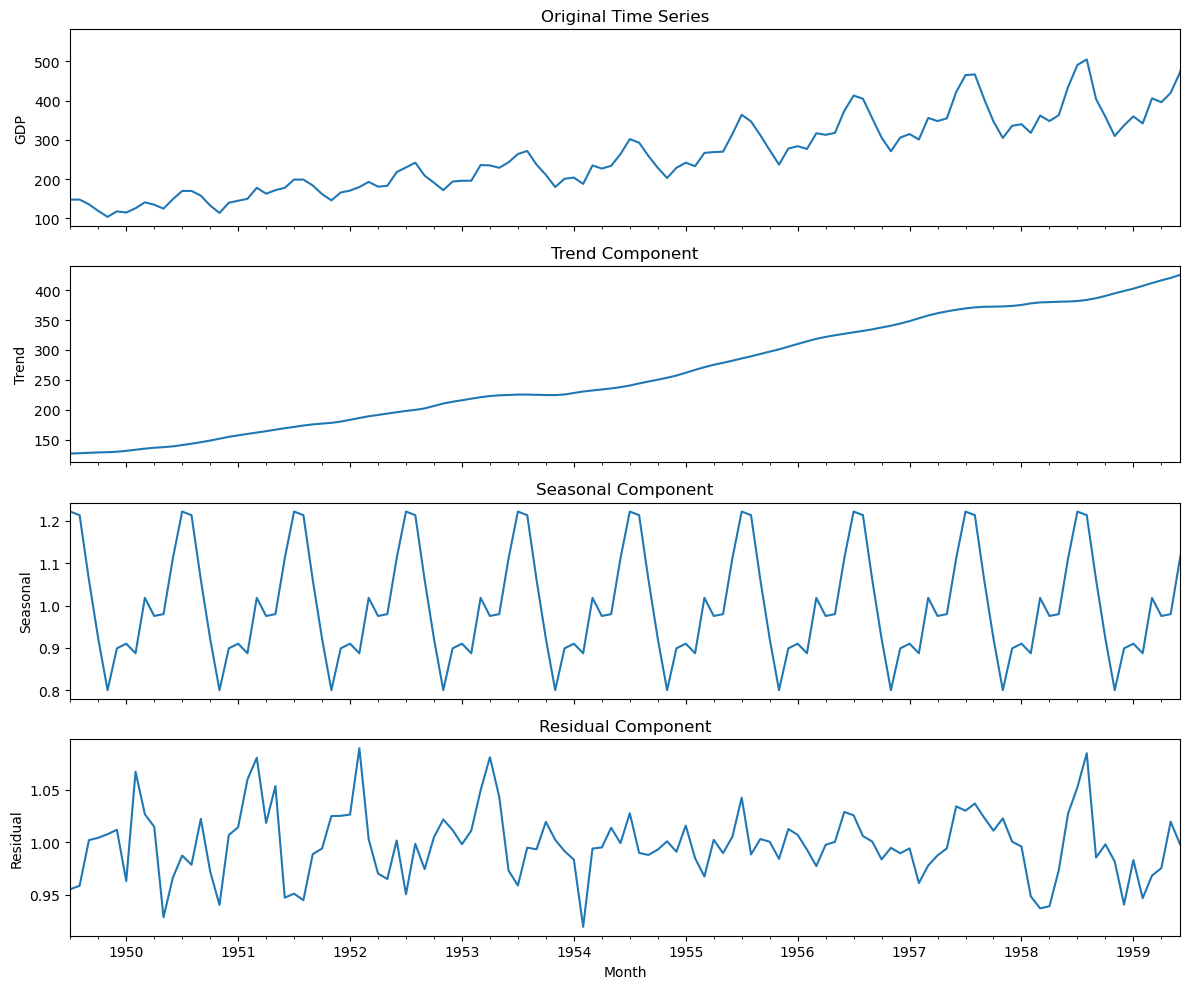

In [11]:
result = seasonal_decompose(airline_series, model='multiplicative', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('GDP')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    airline_series,             # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=2,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(3, 2, 0)(1, 0, 1, 12)


In [13]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 2
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(airline_series,                # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,2,0)(0,0,0,12)
Running model #15 using SARIMA(0,2,0)(3,0,3,12)
Running model #30 using SARIMA(0,2,1)(3,0,2,12)
Running model #45 using SARIMA(0,2,2)(3,0,1,12)
Running model #60 using SARIMA(0,2,3)(3,0,0,12)
Running model #75 using SARIMA(1,2,0)(2,0,3,12)
Running model #90 using SARIMA(1,2,1)(2,0,2,12)
Running model #105 using SARIMA(1,2,2)(2,0,1,12)
Running model #120 using SARIMA(1,2,3)(2,0,0,12)
Running model #135 using SARIMA(2,2,0)(1,0,3,12)
Running model #150 using SARIMA(2,2,1)(1,0,2,12)
Running model #165 using SARIMA(2,2,2)(1,0,1,12)
Running model #180 using SARIMA(2,2,3)(1,0,0,12)
Running model #195 using SARIMA(3,2,0)(0,0,3,12)
Running model #210 using SARIMA(3,2,1)(0,0,2,12)
Running model #225 using SARIMA(3,2,2)(0,0,1,12)
Running model #240 using SARIMA(3,2,3)(0,0,0,12)
Running model #255 using SARIMA(3,2,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,63,"(0, 2, 3)","(3, 0, 3)",683.150709,685.935519,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,127,"(1, 2, 3)","(3, 0, 3)",683.85677,687.241386,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,59,"(0, 2, 3)","(2, 0, 3)",683.967004,686.217004,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,119,"(1, 2, 3)","(1, 0, 3)",685.202989,687.452989,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,55,"(0, 2, 3)","(1, 0, 3)",685.645415,687.423193,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


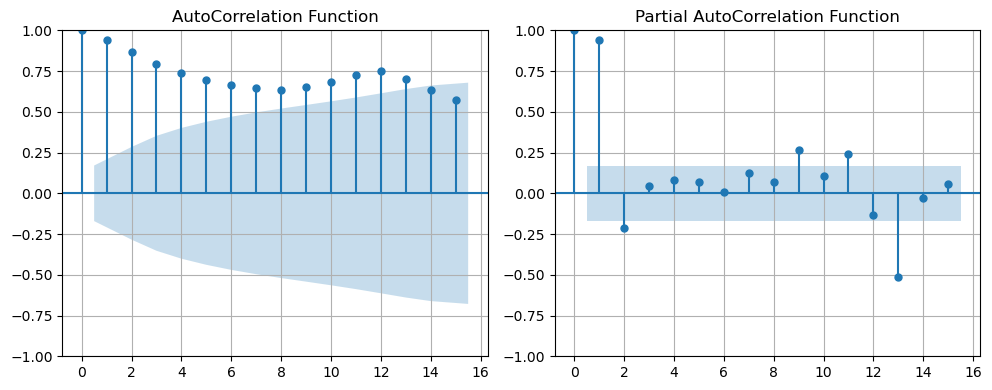

In [14]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(airline_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(airline_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_320 = SARIMAX(airline_series,                      # Time series data
                    order=(3, 2, 0),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 1, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_320 = model_320.fit()

# Display summary of the model
print(model_fit_320.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  132
Model:             SARIMAX(3, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -437.272
Date:                              Wed, 16 Apr 2025   AIC                            886.544
Time:                                      13:18:12   BIC                            903.014
Sample:                                  01-01-1949   HQIC                           893.229
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0491      0.098    -10.672      0.000      -1.242      -0.856
ar.L2         -0.63

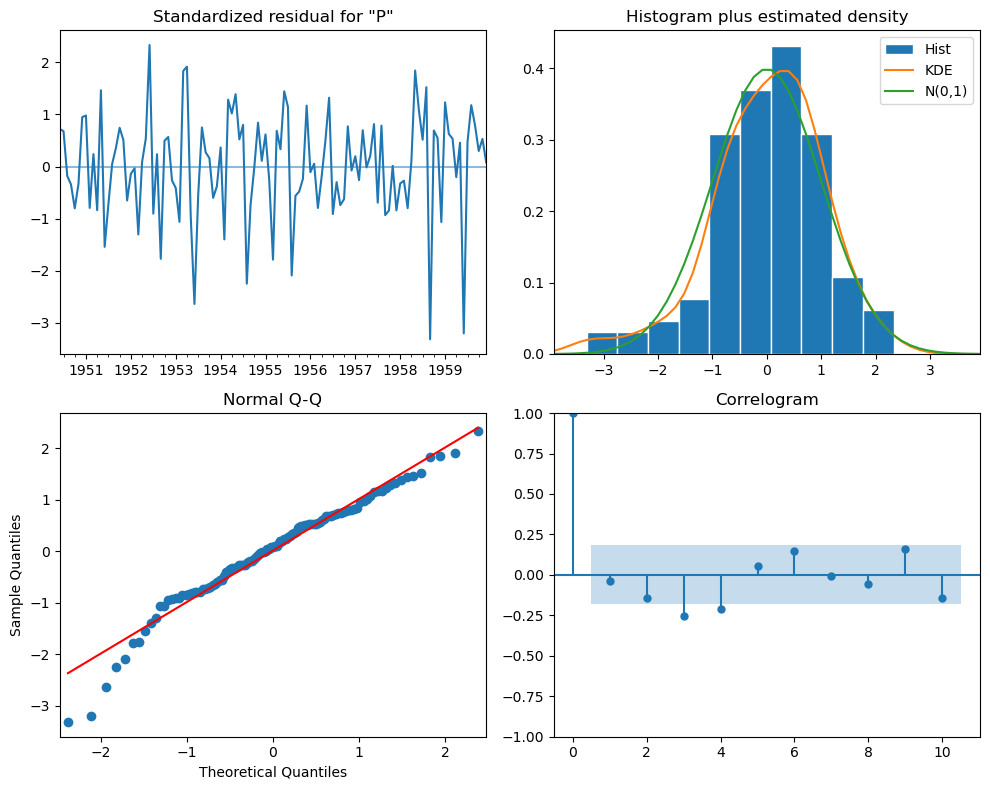

In [16]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_320.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [17]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_320.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.075177,0.783942
2,1.884044,0.389839
3,8.312050,0.039984
4,12.395439,0.014641
5,12.620819,0.027203
6,14.623118,0.023400
7,14.662540,0.040577
8,15.188395,0.055584
9,15.206407,0.085420
10,17.641855,0.061314


In [18]:
from statsmodels.stats.stattools import durbin_watson

# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.6836
Conclusion: No significant autocorrelation.


In [19]:
# Forecast the next steps time points
forecast_12 = model_fit_320.get_forecast(steps=12)

# Extract predicted mean and confidence intervals
forecast_mean_12 = forecast_12.predicted_mean
conf_int_12 = forecast_12.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_12.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Passengers']

test['Lower 95% CI'] = conf_int_12.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_12.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Passengers,Forecast,Error,Lower 95% CI,Upper 95% CI
Month,,,,,
1960-01-01,417,430.542474,13.542474,409.636358,451.448590
1960-02-01,391,415.595916,24.595916,386.747151,444.444681
1960-03-01,419,492.831893,73.831893,452.153266,533.510521
1960-04-01,461,486.612814,25.612814,431.627729,541.597899
1960-05-01,472,515.301601,43.301601,444.988445,585.614757
1960-06-01,535,597.481015,62.481015,510.832968,684.129062
1960-07-01,622,684.452757,62.452757,579.907829,788.997686
1960-08-01,606,701.540838,95.540838,578.144434,824.937241
1960-09-01,508,596.907934,88.907934,453.640487,740.175380


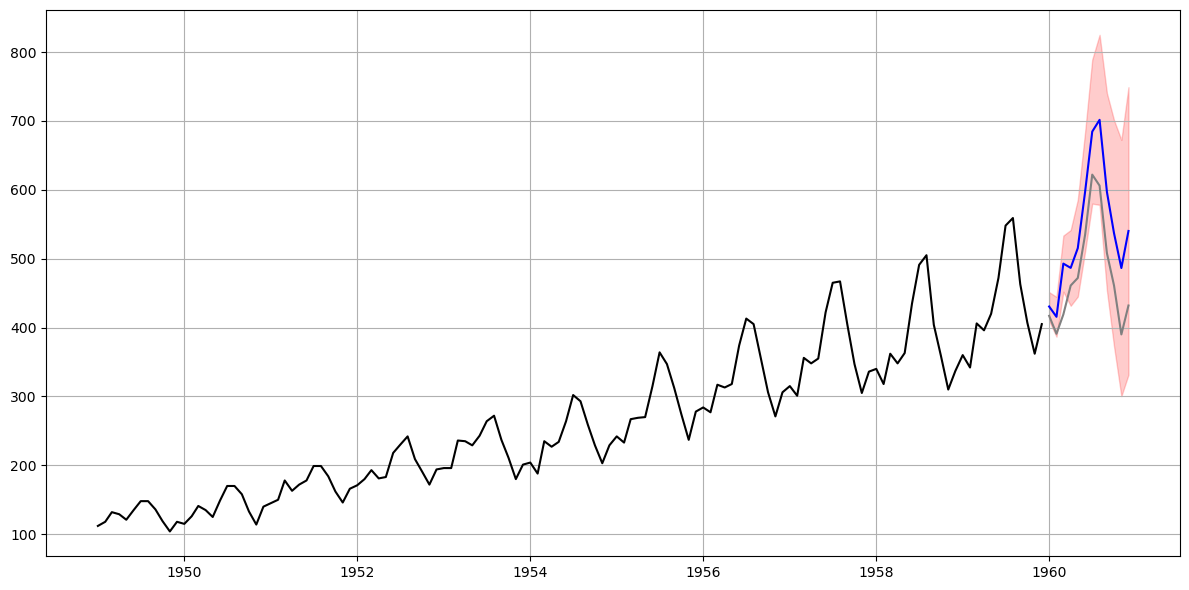

In [20]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Passengers'], label='Train', color='black')                      
plt.plot(test.index, test['Passengers'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast'], label='Forecasting', color='blue') 

ax.set_xlabel('Date')
ax.set_ylabel('Number of Air Passengers')
ax.set_title('Passenger Counts Over Time')

tick_dates = pd.date_range(start='1949', end='1960', freq='YS')
tick_labels = np.arange(1949, 1961, 1)
ax.set_xticks(tick_dates)
ax.set_xticklabels(tick_labels)
plt.grid(True)    
fig.autofmt_xdate()
plt.tight_layout()
plt.show();

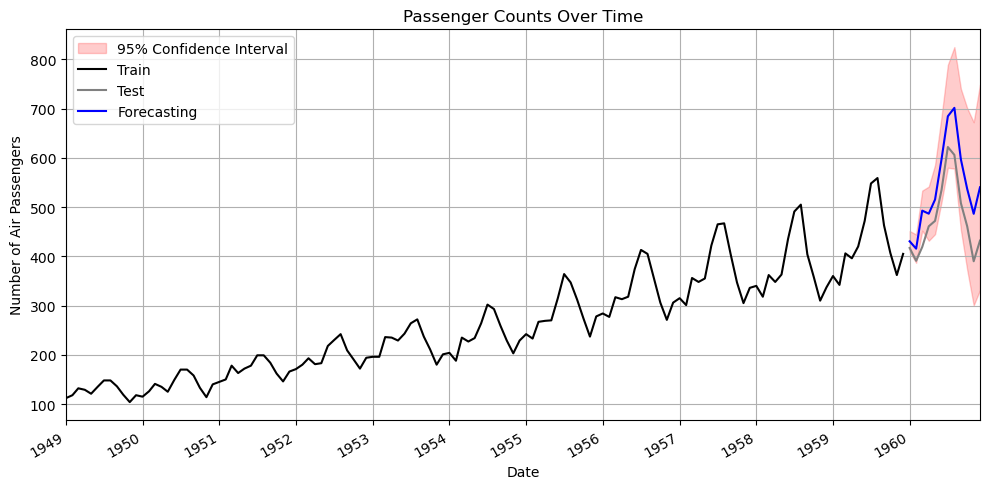

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot
# Plot 95% confidence interval
ax.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

ax.plot(train.index, train['Passengers'], label='Train', color='black')                      
ax.plot(test.index, test['Passengers'], label='Test', color='gray')     
ax.plot(test.index, test['Forecast'], label='Forecasting', color='blue') 

ax.set_xlabel('Date')
ax.set_ylabel('Number of Air Passengers')
ax.set_title('Passenger Counts Over Time')
ax.set_xlim(pd.to_datetime('1949-01-01'), pd.to_datetime('1960-12-01'))
ax.legend()

# Use 12 ticks for 1949–1960
tick_dates = pd.date_range(start='1949', end='1960', freq='YS')
tick_labels = np.arange(1949, 1961, 1)

ax.set_xticks(tick_dates)
ax.set_xticklabels(tick_labels)
plt.grid(True)    

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

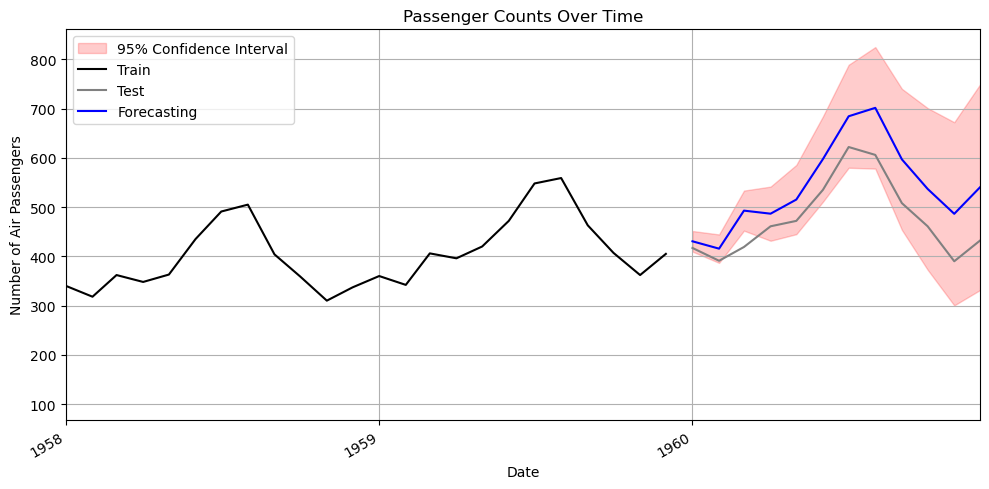

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot
# Plot 95% confidence interval
ax.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

ax.plot(train.index, train['Passengers'], label='Train', color='black')                      
ax.plot(test.index, test['Passengers'], label='Test', color='gray')     
ax.plot(test.index, test['Forecast'], label='Forecasting', color='blue') 

ax.set_xlabel('Date')
ax.set_ylabel('Number of Air Passengers')
ax.set_title('Passenger Counts Over Time')
ax.set_xlim(pd.to_datetime('1958-01-01'), pd.to_datetime('1960-12-01'))
ax.legend()

# Use 12 ticks for 1949–1960
tick_dates = pd.date_range(start='1958', end='1960', freq='YS')
tick_labels = np.arange(1958, 1961, 1)

ax.set_xticks(tick_dates)
ax.set_xticklabels(tick_labels)
plt.grid(True)    

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [23]:
# Create an "exogenous" variable
df['month_index'] = df.index.month

# Split into training and test sets
train['month_index'] = df['month_index'][:-12]     # All values except last 12
test['month_index'] = df['month_index'][-12:]      # Last 12 values

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (132, 2)
Test shape: (12, 6)




(            Passengers  month_index
 Month                              
 1959-08-01         559            8
 1959-09-01         463            9
 1959-10-01         407           10
 1959-11-01         362           11
 1959-12-01         405           12,
 None,
             Passengers    Forecast      Error  Lower 95% CI  Upper 95% CI  \
 Month                                                                       
 1960-01-01         417  430.542474  13.542474    409.636358    451.448590   
 1960-02-01         391  415.595916  24.595916    386.747151    444.444681   
 1960-03-01         419  492.831893  73.831893    452.153266    533.510521   
 1960-04-01         461  486.612814  25.612814    431.627729    541.597899   
 1960-05-01         472  515.301601  43.301601    444.988445    585.614757   
 
             month_index  
 Month                    
 1960-01-01            1  
 1960-02-01            2  
 1960-03-01            3  
 1960-04-01            4  
 1960-05-01            

In [24]:
exog_data = train['month_index']  # Support variable selection
endog_data = train['Passengers']  # Target variable selection

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(3, 2, 0), 
                    seasonal_order=(1, 0, 1, 12),
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  132
Model:             SARIMAX(3, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -437.271
Date:                              Wed, 16 Apr 2025   AIC                            888.541
Time:                                      13:18:13   BIC                            907.756
Sample:                                  01-01-1949   HQIC                           896.340
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0575      1.446     -0.040      0.968      -2.891       2.776
ar.L1          -

In [26]:
# Must match the structure of training exog
exog_test_M = test['month_index']  

# Forecast the next 42 time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=12, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['ForecastM'] = forecast_mean_M.values
test['ErrorM'] = test['ForecastM'] - test['Passengers']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,Passengers,Forecast,Error,Lower 95% CI,Upper 95% CI,month_index,ForecastM,ErrorM,Lower 95% CI M,Upper 95% CI M
Month,,,,,,,,,,
1960-01-01,417,430.542474,13.542474,409.636358,451.448590,1,430.356606,13.356606,409.451456,451.261756
1960-02-01,391,415.595916,24.595916,386.747151,444.444681,2,415.410052,24.410052,386.581807,444.238297
1960-03-01,419,492.831893,73.831893,452.153266,533.510521,3,492.675416,73.675416,452.033884,533.316948
1960-04-01,461,486.612814,25.612814,431.627729,541.597899,4,486.459286,25.459286,431.519644,541.398927
1960-05-01,472,515.301601,43.301601,444.988445,585.614757,5,515.145935,43.145935,444.899951,585.391919


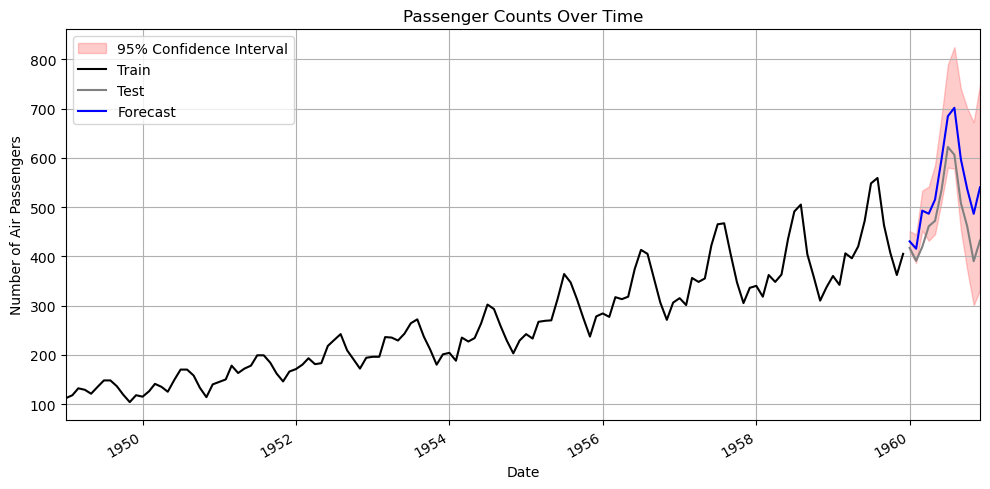

In [27]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))                               # Create figure and axis

# Plot 95% confidence interval
ax.fill_between(test.index,
                conf_int_M.iloc[:, 0],                                # Lower bound
                conf_int_M.iloc[:, 1],                                # Upper bound
                color='red', alpha=0.2, label='95% Confidence Interval')

# Plot series
ax.plot(train.index, train['Passengers'], label='Train', color='black')    
ax.plot(test.index, test['Passengers'], label='Test', color='gray')         
ax.plot(test.index, test['ForecastM'], label='Forecast', color='blue')       

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Air Passengers')
ax.set_title('Passenger Counts Over Time')

# Set X-axis limit
ax.set_xlim(pd.to_datetime('1949-01-01'), pd.to_datetime('1960-12-01'))

# Improve formatting
ax.grid(True)
fig.autofmt_xdate()            # Auto format x-axis dates
ax.legend()                    # Add legend
plt.tight_layout()             # Adjust layout
plt.show()                   # Display plot

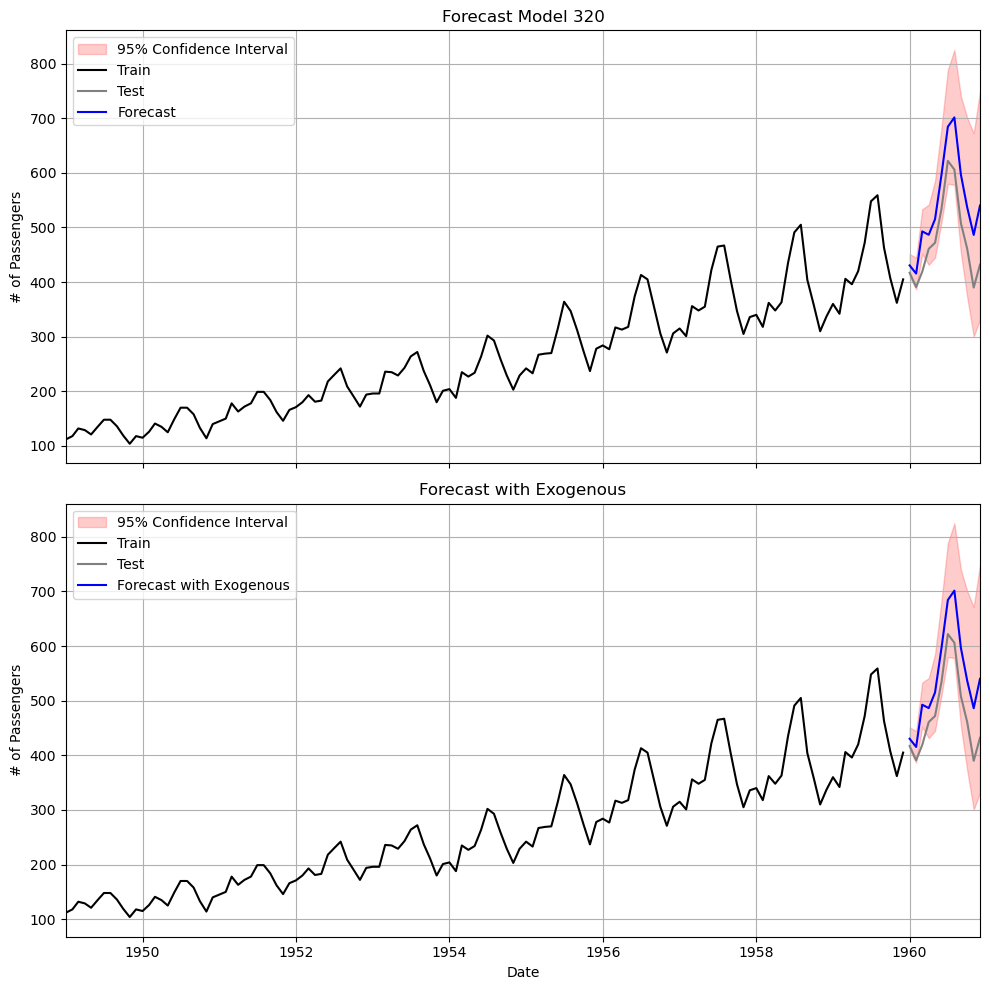

In [28]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast103) ---
axes[0].fill_between(test.index,
                     conf_int_12.iloc[:, 0],
                     conf_int_12.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['Passengers'], label='Train', color='black')
axes[0].plot(test.index, test['Passengers'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast'], label='Forecast', color='blue')

axes[0].set_title('Forecast Model 320')
axes[0].set_ylabel('# of Passengers')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('1949-01-01'), pd.to_datetime('1960-12-01'))

# --- Second Forecast (ForecastM) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['Passengers'], label='Train', color='black')
axes[1].plot(test.index, test['Passengers'], label='Test', color='gray')
axes[1].plot(test.index, test['ForecastM'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('# of Passengers')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('1949-01-01'), pd.to_datetime('1960-12-01'))

# Final layout
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast103
mae_s = mean_absolute_error(test['Passengers'], test['Forecast'])
rmse_s = rmse(test['Passengers'], test['Forecast'])
mape_s = mean_absolute_percentage_error(test['Passengers'], test['Forecast']) * 100

# Metrics for ForecastM
mae_m = mean_absolute_error(test['Passengers'], test['ForecastM'])
rmse_m = rmse(test['Passengers'], test['ForecastM'])
mape_m = mean_absolute_percentage_error(test['Passengers'], test['ForecastM']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

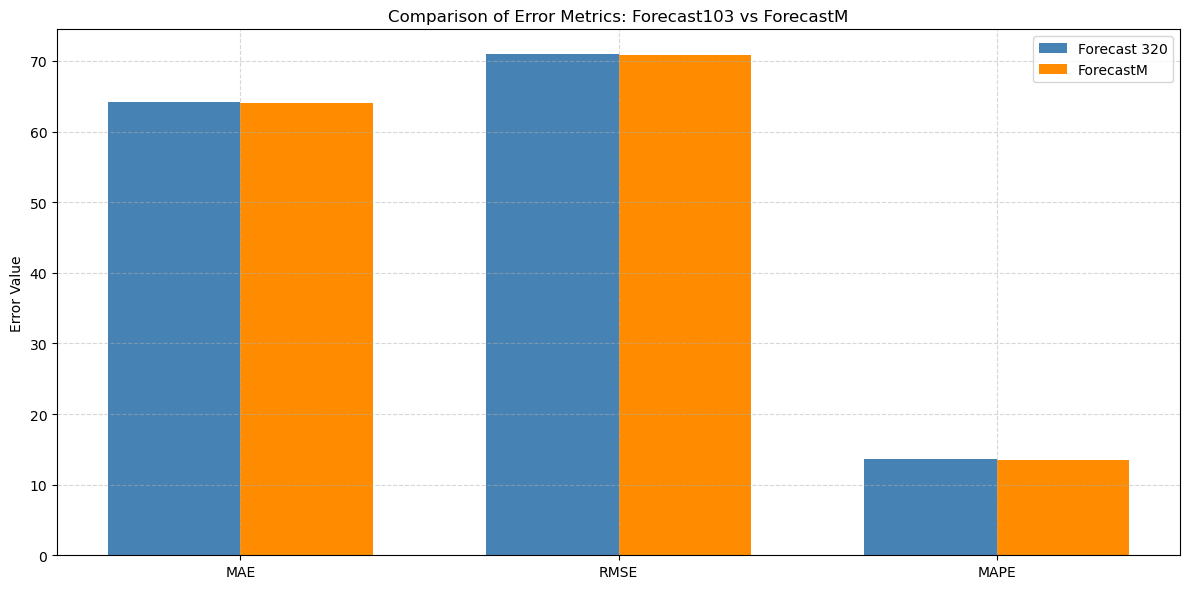

In [31]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast 320', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='ForecastM', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast103 vs ForecastM")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast 320', 'ForecastM']).T
comparison_df

,Forecast 320,ForecastM
MAE,64.229105,64.094462
RMSE,70.925547,70.811704
MAPE,13.591629,13.561557
